In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import GridSearchCV

# !pip install prettytable
from prettytable import PrettyTable

## Split dataframe into two Parts
* Part 1: Predicting race from police dept and county features.
* Part 2: Predicting race from police dept, county features and **WaPo features**. If the victim demographics are better predictors, we can tie back to EDA.

In [3]:
vic_df = pd.read_csv('./data/victim_wapo_lemas_clean1208_with_county_demo.csv')

all_col = ['id', 'name', 'date', 'armed_wapo', 'age', 'gender', 'race',
       'city_wapo', 'state_x', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera', 'longitude', 'latitude', 'is_geocoding_exact',
       'street_address', 'zipcode', 'county_x', 'ORI_agency_id', 'ORI9',
       'ORI9_match_type', 'is_male', 'is_tasered_and_shot', 'is_armed_gun',
       'is_armed_knife', 'is_unarmed', 'is_armed_other', 'race_A', 'race_B',
       'race_H', 'race_N', 'race_O', 'race_W', 'geo_Rural', 'geo_Suburban',
       'geo_Undetermined', 'geo_Urban', 'threat_attack', 'threat_other',
       'threat_undetermined', 'AGENCYNAME', 'POL_BWC', 'PERS_TRN_ACAD',
       'PERS_TRN_FIELD', 'POL_COMP_EXTINV', 'POL_INV_INJRY', 'POL_INV_DTH',
       'POL_INV_DCHG_GUN', 'PERS_CULTURE', 'PERS_CONFLICT', 'PERS_MALE',
       'PERS_FEMALE', 'PERS_TOTAL', 'PERS_WHITE', 'FRAC_WHITE', 'PERS_BLACK',
       'FRAC_BLACK', 'PERS_HISP', 'FRAC_HISP', 'PERS_AMIND', 'FRAC_AMIND',
       'PERS_ASIAN', 'FRAC_ASIAN', 'PERS_HAWPI', 'FRAC_HAWPI', 'PERS_MULTI',
       'FRAC_MULTI', 'PERS_UNK', 'FRAC_UNK', 'FIPS', 'state_y', 'county_y',
       'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'Citizen', 'Income', 'IncomeErr', 'IncomePerCap',
       'IncomePerCapErr', 'Poverty', 'ChildPoverty', 'Professional', 'Service',
       'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp','WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment']

norm100 = ['Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'Poverty', 'ChildPoverty', 'Professional', 'Service',
       'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp','WorkAtHome', 'MeanCommute', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment']

vic_df.loc[:,norm100] = vic_df.loc[:,norm100]/100

part1_cols = ['race','geo_Rural', 'geo_Suburban',
       'geo_Undetermined', 'geo_Urban', 'POL_BWC', 'PERS_TRN_ACAD',
       'PERS_TRN_FIELD', 'POL_COMP_EXTINV', 'POL_INV_INJRY', 'POL_INV_DTH',
       'POL_INV_DCHG_GUN', 'PERS_CULTURE', 'PERS_CONFLICT', 'FRAC_WHITE',
       'FRAC_BLACK', 'FRAC_HISP', 'FRAC_AMIND',
        'FRAC_ASIAN', 'FRAC_HAWPI',
       'FRAC_MULTI',
       'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'Income',
        'Poverty', 'Unemployment']

part2_cols = ['race','age',
       'signs_of_mental_illness',
       'flee', 'body_camera',
       'is_male', 'is_tasered_and_shot', 'is_armed_gun',
       'is_armed_knife', 'is_unarmed', 'is_armed_other', 'geo_Rural', 'geo_Suburban',
       'geo_Undetermined', 'geo_Urban', 'threat_attack', 'threat_other',
       'threat_undetermined', 'POL_BWC', 'PERS_TRN_ACAD',
       'PERS_TRN_FIELD', 'POL_COMP_EXTINV', 'POL_INV_INJRY', 'POL_INV_DTH',
       'POL_INV_DCHG_GUN', 'PERS_CULTURE', 'PERS_CONFLICT', 'FRAC_WHITE',
       'FRAC_BLACK', 'FRAC_HISP', 'FRAC_AMIND',
        'FRAC_ASIAN', 'FRAC_HAWPI',
       'FRAC_MULTI',
       'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'Income',
        'Poverty', 'Unemployment']

vic_df.loc[vic_df['age'].isnull(),'age'] = vic_df.age.mean()
vic_df.loc[vic_df['flee'].isnull(),'flee'] = 'Not fleeing'

vic_df = vic_df.dropna()

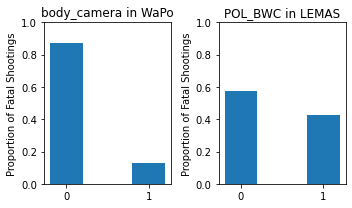

In [9]:
#vic_df[['body_camera','POL_BWC']].hist()
fig,ax=plt.subplots(1,2,figsize=(5,3))
ax[0].bar(x=[0,1],height=vic_df['body_camera'].value_counts(normalize=True),width=0.4)
ax[0].set_title('body_camera in WaPo')
ax[0].set_xticks([0,1])
ax[0].set_ylabel('Proportion of Fatal Shootings')
ax[0].set_ylim(0,1)

ax[1].bar(x=[0,1],height=vic_df['POL_BWC'].value_counts(normalize=True),width=0.4)
ax[1].set_title('POL_BWC in LEMAS')
ax[1].set_xticks([0,1])
ax[1].set_ylabel('Proportion of Fatal Shootings');
ax[1].set_ylim(0,1)

plt.tight_layout()

## Basic Modeling Part 1a
* Predicting race from police dept features (police demographics, policies) etc.

In [12]:
random_state = 109

# load data
data = vic_df[part1_cols]
response, multi_class = 'race', True
total = len(data)

# convert response variable to 0 and n_classes-1
if multi_class:
    le = LabelEncoder()
    data_ = data.copy()
    data_[response] = le.fit_transform(data.copy()[response])
    print(f'Response variable classes: {le.classes_}')

data = data_
data = pd.get_dummies(data)
data

Response variable classes: ['A' 'B' 'H' 'N' 'O' 'W']


,race,geo_Rural,geo_Suburban,geo_Undetermined,geo_Urban,POL_BWC,PERS_TRN_ACAD,PERS_TRN_FIELD,POL_COMP_EXTINV,POL_INV_INJRY,...,FRAC_MULTI,Hispanic,White,Black,Native,Asian,Pacific,Income,Poverty,Unemployment
0,0,1,0,0,0,0,720,480,0,1,...,0.0,0.087,0.819,0.010,0.025,0.015,0.002,50406.0,0.172,0.129
1,5,0,1,0,0,1,920,1640,0,0,...,0.0,0.162,0.682,0.018,0.004,0.092,0.004,66754.0,0.118,0.076
2,2,0,0,0,1,1,960,480,0,1,...,0.0,0.137,0.691,0.090,0.007,0.042,0.000,50657.0,0.151,0.069
3,5,0,0,0,1,1,1304,640,1,0,...,0.0,0.153,0.412,0.053,0.002,0.335,0.004,81294.0,0.132,0.068
4,2,0,1,0,0,1,840,720,0,1,...,0.0,0.287,0.669,0.010,0.005,0.013,0.001,60572.0,0.129,0.066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,5,1,0,0,0,0,0,520,0,0,...,0.0,0.027,0.899,0.020,0.023,0.005,0.000,44549.0,0.146,0.074
4856,5,0,1,0,0,0,560,616,0,0,...,0.0,0.105,0.809,0.031,0.005,0.025,0.001,47801.0,0.161,0.050
4857,2,0,1,0,0,1,1114,720,1,0,...,0.0,0.416,0.317,0.185,0.002,0.065,0.001,54457.0,0.180,0.075
4858,2,0,0,0,1,1,1304,640,1,0,...,0.0,0.153,0.412,0.053,0.002,0.335,0.004,81294.0,0.132,0.068


In [23]:
# splits
train_size = 0.8

x_train_original, x_test_original, y_train, y_test = train_test_split(data.drop(response, axis=1), data[response],
                                                    train_size=train_size, random_state=random_state,
                                                    stratify=data['race'])
col_labels = x_train_original.columns

scaler = StandardScaler().fit(x_train_original)
x_train = scaler.transform(x_train_original)
x_test = scaler.transform(x_test_original)

print(f'Train size: {len(x_train)/len(data):.2f}')
print(f'Test size: {len(x_test)/len(data):.2f}')

Train size: 0.80
Test size: 0.20


In [14]:
baseline_train_score = accuracy_score(np.ones_like(y_train) * y_train.value_counts().idxmax(), y_train)
print(f'Naive baseline accuracy (train): {baseline_train_score:.3f}')

baseline_test_score = accuracy_score(np.ones_like(y_test) * y_test.value_counts().idxmax(), y_test)
print(f'Naive baseline accuracy (test): {baseline_test_score:.3f}')

Naive baseline accuracy (train): 0.492
Naive baseline accuracy (test): 0.493


In [29]:
# county level naive model

#Y = vic_df['race'].astype('category').cat.codes
#X = vic_df[part2_cols] # this doesn't really matter
y_hat_train = []
y_hat_test = []

for ind,row in x_train_original.iterrows():
    race_frac = [row.Asian, row.Black, row.Hispanic, row.Native, 0, row.White]
    y_hat_train.append(np.argmax(race_frac))

for ind,row in x_test_original.iterrows():
    race_frac = [row.Asian, row.Black, row.Hispanic, row.Native, 0, row.White]
    y_hat_test.append(np.argmax(race_frac))
    
acc_naive_train = accuracy_score(y_train,y_hat_train)
acc_naive_test = accuracy_score(y_test,y_hat_test)

print(f'Using county-level demographic data, naive model train accuracy: {acc_naive_train:.4f}')
print(f'Using county-level demographic data, naive model test accuracy: {acc_naive_test:.4f}\n')

#np.array([0.49219099, 0.29585007, 0.17425257, 0.01584114, 0.01204819,0.00981705])
#5 1 2 0 3 4
print(data['race'].value_counts())
print(data['race'].value_counts().values / sum(data['race'].value_counts().values))

Using county-level demographic data, naive model train accuracy: 0.5568
Using county-level demographic data, naive model test accuracy: 0.5741

5    2206
1    1326
2     781
0      71
3      54
4      44
Name: race, dtype: int64
[0.49219099 0.29585007 0.17425257 0.01584114 0.01204819 0.00981705]


In [7]:
# model fitting
class Model():
    def __init__(self, model):
        self.model = model.fit(x_train, y_train)
    
    def cv(self):
        cv = cross_validate(self.model, x_train, y_train, cv=5, return_train_score=True, scoring='accuracy')
        train_score = np.mean(abs(cv['train_score']))
        val_score = np.mean(abs(cv['test_score']))
        return train_score, val_score

    def test_accuracy(self):
        return self.model.score(x_test, y_test)
    
    def importance(self):
        pi = permutation_importance(self.model, x_test, y_test, random_state=random_state)
        
        plt.figure(figsize=(5,5))
        
        sorted_idx = np.argsort(pi.importances_mean)[-10:]
        indices = np.arange(0, len(pi.importances_mean[-10:])) + 0.5
        
        plt.barh(indices, pi.importances_mean[sorted_idx], height=0.7)
        plt.yticks(indices, col_labels[sorted_idx])
        plt.ylim((0, len(pi.importances_mean[-10:])))
        plt.xlabel("Permutation Feature Importance")
        plt.title(f'{type(self.model).__name__}')


knn = Model(KNeighborsClassifier())
logit = Model(LogisticRegression(multi_class='ovr', penalty='none', max_iter=1000, random_state=random_state))
logit_lasso = Model(LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear', max_iter=1000, random_state=random_state))
dtree = Model(DecisionTreeClassifier(max_depth=5, random_state=random_state))
forest = Model(RandomForestClassifier(max_depth=5, random_state=random_state))
boost = Model(AdaBoostClassifier(random_state=random_state))

In [8]:
knn_cv = knn.cv()
logit_cv = logit.cv()
logit_lasso_cv = logit_lasso.cv()
dtree_cv = dtree.cv()
forest_cv = forest.cv()
boost_cv = boost.cv()

x = PrettyTable()
x.field_names = ["Model", "CV Train Accuracy", "CV Validation Accuracy"]
x.add_rows(
    [
        ["KNN", knn_cv[0], knn_cv[1]],
        ["Logistic Regression", logit_cv[0], logit_cv[1]],
        ["Lasso-Logistic Regression", logit_lasso_cv[0], logit_lasso_cv[1]],
        ["Decision Tree (max_depth=5)", dtree_cv[0], dtree_cv[1]],
        ["Random Forest (max_depth=5)", forest_cv[0], forest_cv[1]],
        ["AdaBoost", boost_cv[0], boost_cv[1]]
    ]
)

x.align = "l"
x.float_format = '.3'

print('Accuracies for dataset1')
print(x)

Accuracies for dataset1
+-----------------------------+-------------------+------------------------+
| Model                       | CV Train Accuracy | CV Validation Accuracy |
+-----------------------------+-------------------+------------------------+
| KNN                         | 0.704             | 0.597                  |
| Logistic Regression         | 0.654             | 0.648                  |
| Lasso-Logistic Regression   | 0.653             | 0.648                  |
| Decision Tree (max_depth=5) | 0.674             | 0.636                  |
| Random Forest (max_depth=5) | 0.687             | 0.658                  |
| AdaBoost                    | 0.507             | 0.496                  |
+-----------------------------+-------------------+------------------------+


## Random Forest Tuning Part 1b
* Predicting race from police dept features (police demographics, policies) etc.
* Database: victim_lemas_only1208.csv

In [9]:
n_estimators = [100, 500, 1000]
max_depth = np.arange(1, 20, 1)

param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=random_state), param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

best_grid_part1b = grid_search.best_estimator_

print(f'Best RF estimator train accuracy: {best_grid_part1b.score(x_train, y_train)}')
print(f'Best RF estimator test accuracy: {best_grid_part1b.score(x_test, y_test)}')

Fitting 3 folds for each of 57 candidates, totalling 171 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:  1.3min finished


{'max_depth': 6, 'n_estimators': 100}
Best RF estimator train accuracy: 0.694560669456067
Best RF estimator test accuracy: 0.6399108138238573


Text(0.5, 1.0, "RandomForestClassifier\n{'max_depth': 6, 'n_estimators': 100}")

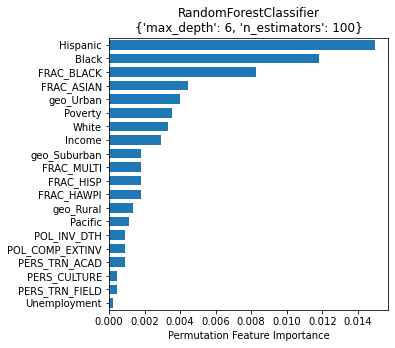

In [10]:
pi = permutation_importance(best_grid_part1b, x_test, y_test, random_state=random_state)

plt.figure(figsize=(5,5))

n_features = 20

sorted_idx = np.argsort(pi.importances_mean)[-n_features:]
indices = np.arange(0, len(pi.importances_mean[-n_features:])) + 0.5

plt.barh(indices, pi.importances_mean[sorted_idx], height=0.7)
plt.yticks(indices, col_labels[sorted_idx])
plt.ylim((0, len(pi.importances_mean[-n_features:])))
plt.xlabel("Permutation Feature Importance")
plt.title(f'{type(best_grid_part1b).__name__}\n{grid_search.best_params_}')

<hr>

## Basic Modeling Part 2a
* Predicting race from police dept features + WaPo features. If the victim demographics are better predictors, we can tie back to EDA

In [11]:
random_state = 109

# load data
data = vic_df[part2_cols]
response, multi_class = 'race', True
total = len(data)

# convert response variable to 0 and n_classes-1
if multi_class:
    le = LabelEncoder()
    data_ = data.copy()
    data_[response] = le.fit_transform(data.copy()[response])
    print(f'Response variable classes: {le.classes_}')

data = data_
data = pd.get_dummies(data)

Response variable classes: ['A' 'B' 'H' 'N' 'O' 'W']


In [12]:
# splits
train_size = 0.8

x_train, x_test, y_train, y_test = train_test_split(data.drop(response, axis=1), data[response],
                                                    train_size=train_size, random_state=random_state,
                                                    stratify=data['race'])
col_labels = x_train.columns

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print(f'Train size: {len(x_train)/len(data):.2f}')
print(f'Test size: {len(x_test)/len(data):.2f}')

Train size: 0.80
Test size: 0.20


In [13]:
baseline_train_score = accuracy_score(np.ones_like(y_train) * y_train.value_counts().idxmax(), y_train)
print(f'Naive baseline accuracy: {baseline_train_score:.3f}')

Naive baseline accuracy: 0.492


In [14]:
# model fitting
knn = Model(KNeighborsClassifier())
logit = Model(LogisticRegression(multi_class='ovr', penalty='none', max_iter=10000, random_state=random_state))
logit_lasso = Model(LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear', max_iter=1000, random_state=random_state))
dtree = Model(DecisionTreeClassifier(max_depth=5, random_state=random_state))
forest = Model(RandomForestClassifier(max_depth=5, random_state=random_state))
boost = Model(AdaBoostClassifier(random_state=random_state))

In [15]:
knn_cv = knn.cv()
logit_cv = logit.cv()
logit_lasso_cv = logit_lasso.cv()
dtree_cv = dtree.cv()
forest_cv = forest.cv()
boost_cv = boost.cv()

x = PrettyTable()
x.field_names = ["Model", "CV Train Accuracy", "CV Validation Accuracy"]
x.add_rows(
    [
        ["KNN", knn_cv[0], knn_cv[1]],
        ["Logistic Regression", logit_cv[0], logit_cv[1]],
        ["Lasso-Logistic Regression", logit_lasso_cv[0], logit_lasso_cv[1]],
        ["Decision Tree (max_depth=5)", dtree_cv[0], dtree_cv[1]],
        ["Random Forest (max_depth=5)", forest_cv[0], forest_cv[1]],
        ["AdaBoost", boost_cv[0], boost_cv[1]]
    ]
)

x.align = "l"
x.float_format = '.3'

print('Accuracies for dataset2')
print(x)

Accuracies for dataset2
+-----------------------------+-------------------+------------------------+
| Model                       | CV Train Accuracy | CV Validation Accuracy |
+-----------------------------+-------------------+------------------------+
| KNN                         | 0.721             | 0.600                  |
| Logistic Regression         | 0.678             | 0.669                  |
| Lasso-Logistic Regression   | 0.678             | 0.668                  |
| Decision Tree (max_depth=5) | 0.680             | 0.649                  |
| Random Forest (max_depth=5) | 0.700             | 0.669                  |
| AdaBoost                    | 0.508             | 0.489                  |
+-----------------------------+-------------------+------------------------+


## Random Forest Tuning Part 2b
* Predicting race from police dept features + WaPo features. If the victim demographics are better predictors, we can tie back to EDA

In [16]:
n_estimators = [100, 500, 1000]
max_depth = np.arange(1, 20, 1)

param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=random_state), param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

best_grid_part2b = grid_search.best_estimator_

print(f'Best RF estimator train accuracy: {best_grid_part2b.score(x_train, y_train)}')
print(f'Best RF estimator test accuracy: {best_grid_part2b.score(x_test, y_test)}')


Fitting 3 folds for each of 57 candidates, totalling 171 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:  1.3min finished


{'max_depth': 7, 'n_estimators': 500}
Best RF estimator train accuracy: 0.7319386331938633
Best RF estimator test accuracy: 0.6566332218506131


Text(0.5, 1.0, "RandomForestClassifier\n{'max_depth': 7, 'n_estimators': 500}")

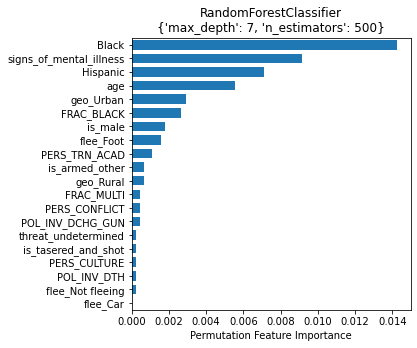

In [17]:
# feature importance
pi = permutation_importance(best_grid_part2b, x_test, y_test, random_state=random_state)

plt.figure(figsize=(5,5))

n_features = 20

sorted_idx = np.argsort(pi.importances_mean)[-n_features:]
indices = np.arange(0, len(pi.importances_mean[-n_features:])) + 0.5

plt.barh(indices, pi.importances_mean[sorted_idx], height=0.7)
plt.yticks(indices, col_labels[sorted_idx])
plt.ylim((0, len(pi.importances_mean[-n_features:])))
plt.xlabel("Permutation Feature Importance")
plt.title(f'{type(best_grid_part2b).__name__}\n{grid_search.best_params_}')